In [8]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [10]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

In [11]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [12]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


In [13]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

In [14]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [37]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )


Device used : cpu


In [38]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [39]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [40]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)


In [41]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        #aug, None
    )
    save_history.append(clf.history["valid_auc"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.66862 | train_auc: 0.76412 | valid_auc: 0.75829 |  0:00:01s
epoch 1  | loss: 0.51328 | train_auc: 0.81793 | valid_auc: 0.81763 |  0:00:04s
epoch 2  | loss: 0.468   | train_auc: 0.84949 | valid_auc: 0.85203 |  0:00:05s
epoch 3  | loss: 0.45429 | train_auc: 0.86924 | valid_auc: 0.86876 |  0:00:07s
epoch 4  | loss: 0.42633 | train_auc: 0.88043 | valid_auc: 0.87916 |  0:00:09s
epoch 5  | loss: 0.41388 | train_auc: 0.89286 | valid_auc: 0.88861 |  0:00:11s
epoch 6  | loss: 0.40108 | train_auc: 0.90147 | valid_auc: 0.89255 |  0:00:14s
epoch 7  | loss: 0.39266 | train_auc: 0.9082  | valid_auc: 0.90194 |  0:00:16s
epoch 8  | loss: 0.38367 | train_auc: 0.91092 | valid_auc: 0.90123 |  0:00:18s
epoch 9  | loss: 0.36867 | train_auc: 0.91528 | valid_auc: 0.90559 |  0:00:20s
epoch 10 | loss: 0.36872 | train_auc: 0.91347 | valid_auc: 0.90866 |  0:00:21s
epoch 11 | loss: 0.35732 | train_auc: 0.91505 | valid_auc: 0.90878 |  0:00:23s
epoch 12 | loss: 0.35746 | train_auc: 0.91844 | vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


AssertionError: ignored

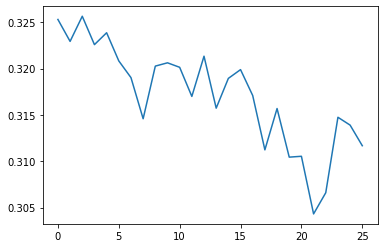

In [42]:
plt.plot(clf.history['loss'])


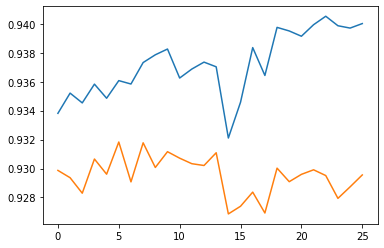

In [43]:
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])


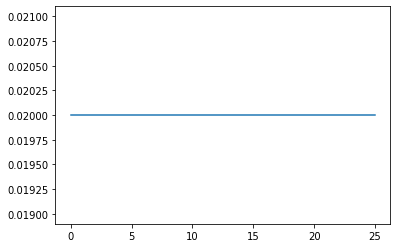

In [44]:
plt.plot(clf.history['lr'])


In [45]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")


BEST VALID SCORE FOR census-income : 0.9318311608887525
FINAL TEST SCORE FOR census-income : 0.924700152798148


In [46]:
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)


In [47]:
clf.predict(X_test)



array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'wealthy'], dtype='<U11')

In [48]:
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)


Successfully saved model at ./tabnet_model_test_1.zip


In [49]:
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)


Device used : cpu
Device used : cpu


In [50]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")


FINAL TEST SCORE FOR census-income : 0.924700152798148


In [51]:
assert(test_auc == loaded_test_auc)


In [52]:
loaded_clf.predict(X_test)


array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'wealthy'], dtype='<U11')

In [53]:
clf.feature_importances_


array([7.58610574e-02, 2.41781841e-02, 1.27599872e-04, 4.61105860e-02,
       1.28297519e-01, 1.27612046e-01, 3.80639717e-02, 1.16721783e-01,
       5.56453401e-05, 5.52511066e-02, 1.71658202e-01, 1.18428982e-01,
       9.51610289e-02, 2.47228786e-03])

In [54]:
explain_matrix, masks = clf.explain(X_test)


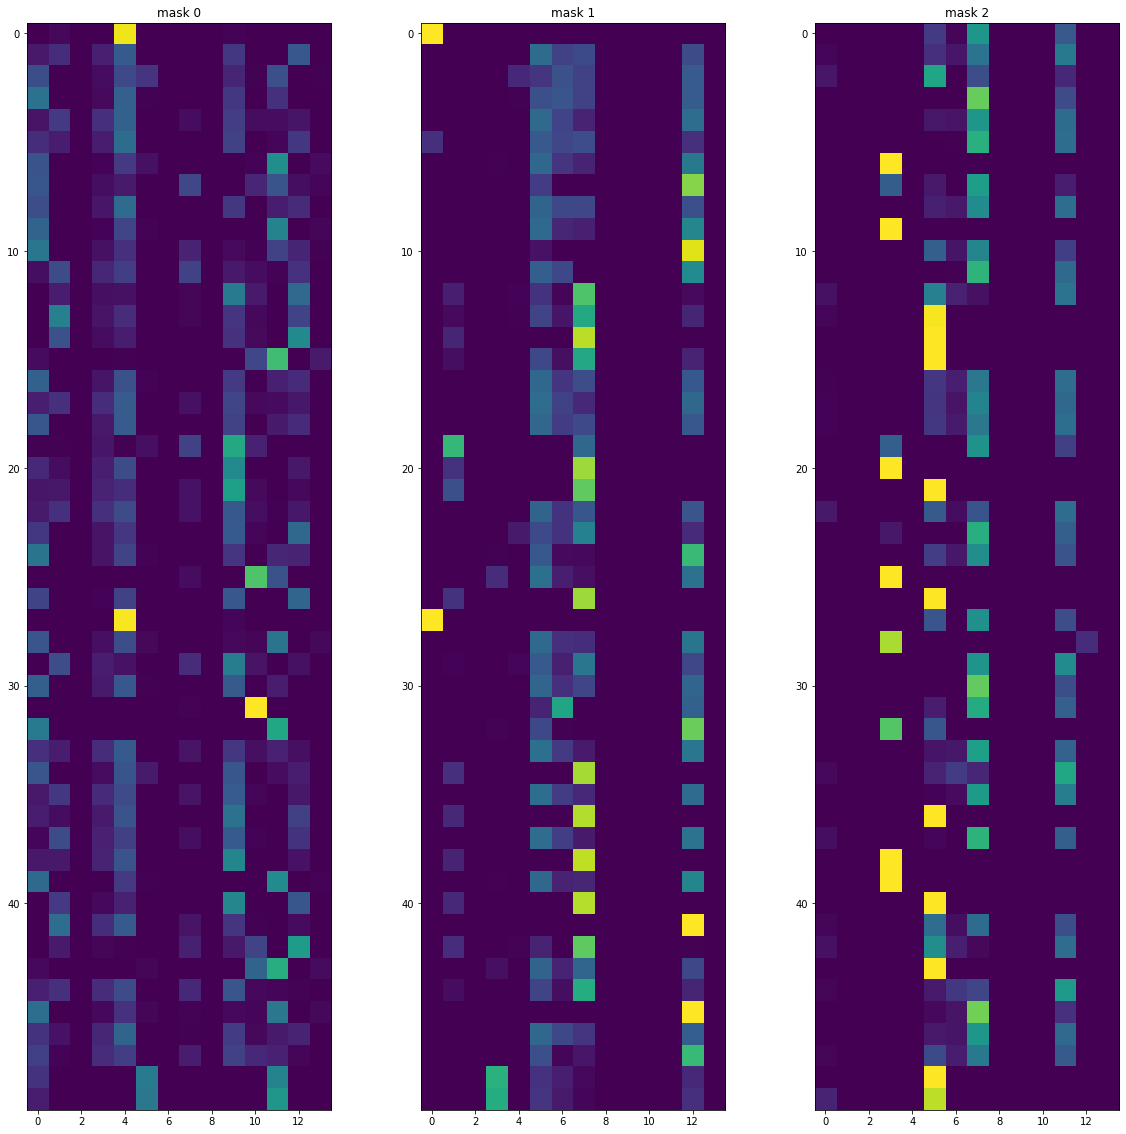

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
